<a href="https://colab.research.google.com/github/CarolinaOliveira001/SupremeCourtJudgementPrediction/blob/main/secondTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [176]:
df = pd.read_csv("justice.csv")
df = df[["facts", "issue_area", "first_party_winner"]]
df.head(5)

,facts,issue_area,first_party_winner
0,"<p>In 1970, Jane Roe (a fictional name used in...",NaN,True
1,<p>Joan Stanley had three children with Peter ...,Civil Rights,True
2,<p>John Giglio was convicted of passing forged...,Due Process,True
3,"<p>The Idaho Probate Code specified that ""male...",Civil Rights,True
4,"<p>Miller, after conducting a mass mailing cam...",First Amendment,True


In [177]:
df['issue_area'] = df['issue_area'].replace({"Due Process": "Others", "Privacy": "Others", "Federal Taxation": "Others", 
                                                     "Unions": "Others", "Federalism": "Others", "Attorneys": "Others",
                                                     "Miscellaneous": "Others", "Interstate Relations": "Others", "Private Action": "Others"})

In [178]:
df.isna().sum()

facts                   0
issue_area            142
first_party_winner     15
dtype: int64

In [179]:
df.dropna(subset=['first_party_winner'], inplace=True)

In [180]:
df.isna().sum()

facts                   0
issue_area            129
first_party_winner      0
dtype: int64

In [181]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [182]:
le.fit(df["first_party_winner"])

LabelEncoder()

In [183]:
df["first_party_winner"] = le.transform(df["first_party_winner"])

In [184]:
df_withNA = df[df['issue_area'].isna()]
df_withNA = df_withNA.reset_index(drop=True)

In [185]:
df_withoutNA = df.dropna(subset=['issue_area'])
df_withoutNA = df_withoutNA.reset_index(drop=True)

In [186]:
print("There are", df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 549349 words in the dataframe.


In [187]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [188]:
stop_words = stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()

In [189]:
pattern = r'[' + string.punctuation + ']'

def clean_text(text, stemming = False, lemmatization = False):
    """
        text: a string
        
        return: modified initial string
    """
    text = re.sub(pattern, " ", str(text))
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(' +', ' ', text)
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    if stemming:
        st = PorterStemmer()
        text = " ".join([st.stem(w) for w in text.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        text = ' '.join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in text.split()])
    return text
    

In [190]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [191]:
df_withoutNA['facts'] = df_withoutNA['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))

In [192]:
df_withoutNA.head(3)

,facts,issue_area,first_party_winner
0,joan stanley three children peter stanley stan...,Civil Rights,1
1,john giglio convict pass forge money order app...,Others,1
2,idaho probate code specify males must prefer f...,Civil Rights,1


In [193]:
print("There are",df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 322095 words in the dataframe.


In [194]:
my_issue_area = list(set(df_withoutNA["issue_area"]))

# Without deleting most frequent words

In [ ]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 117 ms


In [ ]:
list(set(y_pred))

['Economic Activity',
 'Others',
 'First Amendment',
 'Criminal Procedure',
 'Civil Rights']

In [ ]:
list(set(y_test))

['Economic Activity',
 'Others',
 'First Amendment',
 'Criminal Procedure',
 'Judicial Power',
 'Civil Rights']

In [ ]:
import warnings
warnings.filterwarnings('always') #We can set it later to 'ignore'.

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_issue_area))

accuracy 0.5580168776371308
                    precision    recall  f1-score   support

            Others       0.60      0.51      0.55       184
 Economic Activity       0.51      0.99      0.67       258
   First Amendment       0.64      0.63      0.64       161
Criminal Procedure       0.84      0.17      0.28        96
      Civil Rights       0.00      0.00      0.00       111
    Judicial Power       0.56      0.45      0.50       138

          accuracy                           0.56       948
         macro avg       0.53      0.46      0.44       948
      weighted avg       0.53      0.56      0.50       948



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 220 ms, sys: 64 ms, total: 284 ms
Wall time: 224 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6867088607594937
                    precision    recall  f1-score   support

            Others       0.74      0.65      0.69       184
 Economic Activity       0.68      0.98      0.81       258
   First Amendment       0.69      0.71      0.70       161
Criminal Procedure       0.68      0.72      0.70        96
      Civil Rights       0.62      0.21      0.31       111
    Judicial Power       0.64      0.52      0.57       138

          accuracy                           0.69       948
         macro avg       0.68      0.63      0.63       948
      weighted avg       0.68      0.69      0.66       948



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [ ]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 203 ms, sys: 614 µs, total: 204 ms
Wall time: 205 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.7056962025316456
                    precision    recall  f1-score   support

            Others       0.72      0.69      0.71       184
 Economic Activity       0.78      0.94      0.85       258
   First Amendment       0.70      0.70      0.70       161
Criminal Procedure       0.70      0.77      0.74        96
      Civil Rights       0.53      0.31      0.39       111
    Judicial Power       0.62      0.58      0.60       138

          accuracy                           0.71       948
         macro avg       0.67      0.66      0.66       948
      weighted avg       0.69      0.71      0.69       948



In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators= 10, max_depth=10, random_state=10)),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=10))])

In [ ]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 188 ms, sys: 973 µs, total: 189 ms
Wall time: 194 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.4272151898734177
                    precision    recall  f1-score   support

            Others       0.60      0.32      0.42       184
 Economic Activity       0.38      0.97      0.54       258
   First Amendment       0.46      0.35      0.39       161
Criminal Procedure       0.88      0.23      0.36        96
      Civil Rights       0.57      0.04      0.07       111
    Judicial Power       0.48      0.11      0.18       138

          accuracy                           0.43       948
         macro avg       0.56      0.33      0.33       948
      weighted avg       0.52      0.43      0.37       948



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=10)),
               ])
graboos.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=10))])

In [ ]:
%%time
y_pred = graboos.predict(X_test)

CPU times: user 195 ms, sys: 1.8 ms, total: 197 ms
Wall time: 197 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6086497890295358
                    precision    recall  f1-score   support

            Others       0.63      0.54      0.58       184
 Economic Activity       0.70      0.88      0.78       258
   First Amendment       0.63      0.60      0.62       161
Criminal Procedure       0.68      0.64      0.66        96
      Civil Rights       0.47      0.28      0.35       111
    Judicial Power       0.40      0.44      0.42       138

          accuracy                           0.61       948
         macro avg       0.58      0.56      0.57       948
      weighted avg       0.60      0.61      0.60       948



In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import xgboost as xgb

xgboo = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective='multi:softprob'))])

In [ ]:
%%time
y_pred = xgboo.predict(X_test)

CPU times: user 279 ms, sys: 6.79 ms, total: 286 ms
Wall time: 285 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6350210970464135
                    precision    recall  f1-score   support

            Others       0.67      0.60      0.63       184
 Economic Activity       0.74      0.89      0.81       258
   First Amendment       0.63      0.61      0.62       161
Criminal Procedure       0.63      0.70      0.66        96
      Civil Rights       0.47      0.27      0.34       111
    Judicial Power       0.45      0.47      0.46       138

          accuracy                           0.64       948
         macro avg       0.60      0.59      0.59       948
      weighted avg       0.62      0.64      0.62       948



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('kn',KNeighborsClassifier(n_neighbors=3)),
               ])
kn.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('kn', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
%%time
y_pred = kn.predict(X_test)

CPU times: user 384 ms, sys: 1.24 ms, total: 386 ms
Wall time: 388 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.5928270042194093
                    precision    recall  f1-score   support

            Others       0.50      0.70      0.58       184
 Economic Activity       0.66      0.81      0.73       258
   First Amendment       0.63      0.60      0.61       161
Criminal Procedure       0.65      0.48      0.55        96
      Civil Rights       0.50      0.23      0.32       111
    Judicial Power       0.59      0.40      0.47       138

          accuracy                           0.59       948
         macro avg       0.59      0.54      0.54       948
      weighted avg       0.59      0.59      0.58       948



# With deleting some words

In [ ]:
bunchOfWords = "".join(df_withoutNA["facts"].tolist())

We will perform a bag of words and try to find the words that appear 1000

In [ ]:
data_corpus = set()
for word in bunchOfWords.split(" "):
    if word not in data_corpus: 
        data_corpus.add(word)
data_corpus=sorted(data_corpus)

In [ ]:
def convert(set):
    return [*set, ]

data_corpus = convert(data_corpus)

In [ ]:
one_hot_encoding = []
split = bunchOfWords.split(" ")
for word in data_corpus:
    count = split.count(word) 
    if word in split:
        one_hot_encoding.append(count)
    else:
        one_hot_encoding.append(count)

In [ ]:
dfWords = pd.DataFrame({"words": data_corpus, "numberOfFrequency": one_hot_encoding})
dfWords["numberOfFrequency"] = pd.to_numeric(dfWords["numberOfFrequency"])

In [ ]:
irrelevantWords = dfWords[dfWords["numberOfFrequency"] > 1000]
irrelevantWords = set(irrelevantWords["words"])

In [ ]:
def more_clean_text(text):
    text = ' '.join(word for word in text.split() if word not in irrelevantWords) # delete stopwors from text
    return text

In [ ]:
df_withoutNA['facts'] = df_withoutNA['facts'].apply(more_clean_text)

In [ ]:
print("There are",df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 267703 words in the dataframe.


In [ ]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 166 ms, sys: 1.7 ms, total: 167 ms
Wall time: 170 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_issue_area))

accuracy 0.520042194092827
                    precision    recall  f1-score   support

            Others       0.69      0.48      0.57       184
 Economic Activity       0.43      1.00      0.60       258
   First Amendment       0.63      0.61      0.62       161
Criminal Procedure       1.00      0.07      0.14        96
      Civil Rights       0.00      0.00      0.00       111
    Judicial Power       0.64      0.30      0.41       138

          accuracy                           0.52       948
         macro avg       0.57      0.41      0.39       948
      weighted avg       0.55      0.52      0.45       948



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 215 ms, sys: 68.6 ms, total: 283 ms
Wall time: 217 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6835443037974683
                    precision    recall  f1-score   support

            Others       0.76      0.65      0.70       184
 Economic Activity       0.66      0.98      0.79       258
   First Amendment       0.67      0.71      0.69       161
Criminal Procedure       0.73      0.72      0.72        96
      Civil Rights       0.60      0.19      0.29       111
    Judicial Power       0.65      0.51      0.57       138

          accuracy                           0.68       948
         macro avg       0.68      0.63      0.63       948
      weighted avg       0.68      0.68      0.66       948



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [ ]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 165 ms, sys: 15.7 ms, total: 180 ms
Wall time: 167 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.7046413502109705
                    precision    recall  f1-score   support

            Others       0.74      0.68      0.71       184
 Economic Activity       0.75      0.94      0.83       258
   First Amendment       0.68      0.71      0.70       161
Criminal Procedure       0.70      0.76      0.73        96
      Civil Rights       0.55      0.29      0.38       111
    Judicial Power       0.65      0.59      0.62       138

          accuracy                           0.70       948
         macro avg       0.68      0.66      0.66       948
      weighted avg       0.69      0.70      0.69       948



In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators= 10, max_depth=10, random_state=10)),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=10))])

In [ ]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 176 ms, sys: 3.97 ms, total: 180 ms
Wall time: 182 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.4208860759493671
                    precision    recall  f1-score   support

            Others       0.55      0.32      0.40       184
 Economic Activity       0.39      0.98      0.56       258
   First Amendment       0.43      0.35      0.39       161
Criminal Procedure       0.75      0.16      0.26        96
      Civil Rights       0.57      0.04      0.07       111
    Judicial Power       0.34      0.08      0.13       138

          accuracy                           0.42       948
         macro avg       0.51      0.32      0.30       948
      weighted avg       0.48      0.42      0.35       948



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=10)),
               ])
graboos.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=10))])

In [ ]:
%%time
y_pred = graboos.predict(X_test)

CPU times: user 174 ms, sys: 147 µs, total: 174 ms
Wall time: 175 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6054852320675106
                    precision    recall  f1-score   support

            Others       0.64      0.55      0.59       184
 Economic Activity       0.70      0.87      0.77       258
   First Amendment       0.60      0.57      0.59       161
Criminal Procedure       0.65      0.57      0.61        96
      Civil Rights       0.53      0.27      0.36       111
    Judicial Power       0.41      0.52      0.46       138

          accuracy                           0.61       948
         macro avg       0.59      0.56      0.56       948
      weighted avg       0.60      0.61      0.60       948



In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import xgboost as xgb

xgboo = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective='multi:softprob'))])

In [ ]:
%%time
y_pred = xgboo.predict(X_test)

CPU times: user 272 ms, sys: 4.83 ms, total: 277 ms
Wall time: 276 ms


In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6244725738396625
                    precision    recall  f1-score   support

            Others       0.64      0.55      0.59       184
 Economic Activity       0.73      0.91      0.81       258
   First Amendment       0.62      0.58      0.60       161
Criminal Procedure       0.67      0.65      0.66        96
      Civil Rights       0.47      0.29      0.36       111
    Judicial Power       0.44      0.50      0.47       138

          accuracy                           0.62       948
         macro avg       0.59      0.58      0.58       948
      weighted avg       0.62      0.62      0.61       948



In [ ]:
kn = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3)),
               ])
kn.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
%%time
y_pred = kn.predict(X_test)

CPU times: user 315 ms, sys: 2.35 ms, total: 318 ms
Wall time: 322 ms


In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.5780590717299579
                    precision    recall  f1-score   support

            Others       0.47      0.66      0.55       184
 Economic Activity       0.67      0.80      0.73       258
   First Amendment       0.59      0.60      0.60       161
Criminal Procedure       0.66      0.50      0.57        96
      Civil Rights       0.45      0.18      0.26       111
    Judicial Power       0.54      0.41      0.46       138

          accuracy                           0.58       948
         macro avg       0.56      0.52      0.53       948
      weighted avg       0.57      0.58      0.56       948



# Word2Vec

In [ ]:
pip install --upgrade tensorflow-hub

In [ ]:
pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_withoutNA["facts"],df_withoutNA["issue_area"],test_size=0.2,shuffle=True)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
79/79 [==============================] - 1090s 13s/step - loss: -13.0583 - accuracy: 0.2731
Epoch 2/2
79/79 [==============================] - 1056s 13s/step - loss: -40.5781 - accuracy: 0.2762


In [ ]:
y_train

array([1, 3, 2, ..., 0, 1, 3])

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
print(y_predicted)

20/20 [==============================] - 259s 13s/step
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
print('accuracy %s' % accuracy_score(y_predicted, y_test))
print(classification_report(y_test, y_predicted,target_names=my_issue_area))

accuracy 0.254746835443038
                    precision    recall  f1-score   support

            Others       0.00      0.00      0.00       113
    Judicial Power       0.25      1.00      0.41       161
Criminal Procedure       0.00      0.00      0.00       104
 Economic Activity       0.00      0.00      0.00        70
      Civil Rights       0.00      0.00      0.00        69
   First Amendment       0.00      0.00      0.00       115

          accuracy                           0.25       632
         macro avg       0.04      0.17      0.07       632
      weighted avg       0.06      0.25      0.10       632



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Issue Area prediction

In [195]:
second_df = pd.read_csv("us_classactions_verdicts.csv")
second_df = second_df[["target_text", "verdict"]]

In [196]:
second_df.rename(columns = {'target_text':'facts', 'verdict': 'first_party_winner'}, inplace = True)

In [197]:
second_df.head(3)

,facts,first_party_winner
0,Knowing and/or Willful Violation of the Telep...,lose
1,17. Defendants operate an electrical construc...,win
2,(Fair Labor Standards Act Violations) (Viola...,win


In [198]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [199]:
le.fit(second_df["first_party_winner"])

LabelEncoder()

In [200]:
second_df["first_party_winner"] = le.transform(second_df["first_party_winner"])

In [202]:
second_df['facts'] = second_df['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))
df_withNA['facts'] = df_withNA['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))

In [203]:
df_withNA = df_withNA[["facts", "first_party_winner"]]

In [204]:
df_toPredict = pd.concat([df_withNA, second_df])
df_toPredict = df_toPredict.reset_index(drop=True)

In [205]:
df_toPredict

,facts,first_party_winner
0,jane roe fictional name use court document pro...,1
1,wiley bolden residents mobile alabama bring cl...,1
2,county los angeles impose ad valorem tax manuf...,0
3,rincon island artificial island coast ventura ...,1
4,president jimmy carter act without congression...,0
...,...,...
3124,fair labor standards act violations violations...,1
3125,guidelines regularly test user accessibility b...,0
3126,action bring class action plaintiff bring acti...,1
3127,discovery may reveal transmission additional f...,0


In [206]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('logistic', LogisticRegression(n_jobs=1, solver='lbfgs', max_iter=100000)),
               ])

In [ ]:
logreg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'logistic', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'logistic__C', 'logistic__class_weight', 'logistic__dual', 'logistic__fit_intercept', 'logistic__intercept_scaling', 'logistic__l1_ratio', 'logistic__max_iter', 'logistic__multi_class', 'logistic__n_jobs', 'logistic__penalty', 'logistic__random_state', 'logistic__solver', 'logistic__tol', 'logistic__verbose', 'logistic__warm_start'])

In [209]:
params={'logistic__C':[1e4, 1e5, 1e6],
        'logistic__penalty' : ['none', 'l2']}

In [210]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
grid = HalvingGridSearchCV(logreg, cv=5, n_jobs=-1, param_grid=params)

In [211]:
grid.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('vect',
                                               CountVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('tfidf', TfidfTransformer()),
                                              ('logistic',
                                               LogisticRegression(max_iter=100000,
                                                                  n_jobs=1))]),
                    n_jobs=-1,
                    param_grid={'logistic__C': [10000.0, 100000.0, 1000000.0],
                                'logistic__penalty': ['none', 'l2']})

In [212]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)

Best parameter (CV score=0.714):


In [215]:
%%time
from sklearn.metrics import classification_report
y_pred = grid.predict(X_test)

CPU times: user 170 ms, sys: 284 µs, total: 170 ms
Wall time: 178 ms


In [216]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.7072784810126582
                    precision    recall  f1-score   support

    Judicial Power       0.73      0.76      0.75       108
      Civil Rights       0.76      0.94      0.84       173
Criminal Procedure       0.64      0.68      0.66        98
 Economic Activity       0.75      0.79      0.77        71
            Others       0.54      0.31      0.39        81
   First Amendment       0.68      0.54      0.60       101

          accuracy                           0.71       632
         macro avg       0.68      0.67      0.67       632
      weighted avg       0.69      0.71      0.69       632



In [221]:
%%time
from sklearn.metrics import classification_report
y_pred = grid.predict(df_toPredict["facts"])

CPU times: user 6.32 s, sys: 20 ms, total: 6.34 s
Wall time: 6.88 s


In [222]:
y_pred_df = pd.DataFrame({"issue_area": y_pred})

In [231]:
df_toPredict = pd.concat([df_toPredict, y_pred_df], axis = 1)
df_toPredict = df_toPredict[["facts", "issue_area", "first_party_winner"]]

In [232]:
big_df = pd.concat([df_withoutNA, df_toPredict])
big_df = big_df.reset_index(drop=True)

In [233]:
big_df

,facts,issue_area,first_party_winner
0,joan stanley three children peter stanley stan...,Civil Rights,1
1,john giglio convict pass forge money order app...,Others,1
2,idaho probate code specify males must prefer f...,Civil Rights,1
3,miller conduct mass mail campaign advertise sa...,First Amendment,1
4,ernest mandel belgian professional journalist ...,First Amendment,1
...,...,...,...
6283,fair labor standards act violations violations...,Others,1
6284,guidelines regularly test user accessibility b...,Civil Rights,0
6285,action bring class action plaintiff bring acti...,Judicial Power,1
6286,discovery may reveal transmission additional f...,Judicial Power,0


# One Hot Encoding


In [234]:
from sklearn.preprocessing import OneHotEncoder

In [235]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [236]:
encoder_df = pd.DataFrame(encoder.fit_transform(big_df[['issue_area']]).toarray())

In [237]:
encoder_df.columns = ['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']

In [238]:
big_df = big_df.join(encoder_df)
big_df.drop('issue_area', axis=1, inplace=True)

In [239]:
big_df[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']] = big_df[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']].astype(int)

In [240]:
big_df = big_df[["facts", 'Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others', "first_party_winner"]]

In [241]:
big_df

,facts,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others,first_party_winner
0,joan stanley three children peter stanley stan...,1,0,0,0,0,0,1
1,john giglio convict pass forge money order app...,0,0,0,0,0,1,1
2,idaho probate code specify males must prefer f...,1,0,0,0,0,0,1
3,miller conduct mass mail campaign advertise sa...,0,0,0,1,0,0,1
4,ernest mandel belgian professional journalist ...,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
6283,fair labor standards act violations violations...,0,0,0,0,0,1,1
6284,guidelines regularly test user accessibility b...,1,0,0,0,0,0,0
6285,action bring class action plaintiff bring acti...,0,0,0,0,1,0,1
6286,discovery may reveal transmission additional f...,0,0,0,0,1,0,0


In [242]:
big_df.rename(columns = {'first_party_winner':'target'}, inplace = True)

# Second Prediction with TFIDF

In [639]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(big_df, test_size=0.2, random_state=42)

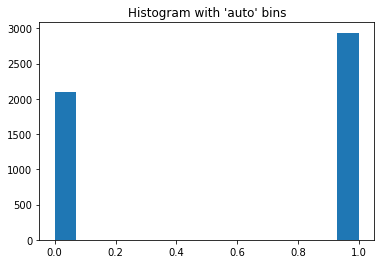

In [640]:
import matplotlib.pyplot as plt
_ = plt.hist(X_train["target"], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [247]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 5.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [641]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [642]:
y_train = X_train["target"]

In [643]:
X_train = X_train.loc[:, X_train.columns != 'target']

In [644]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [645]:
X_train = X_train_ros
y_train = y_train_ros

In [646]:
y_test = X_test["target"]
X_test = X_test.loc[:, X_test.columns != 'target']

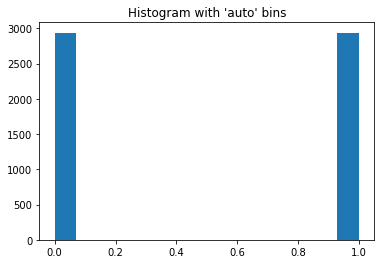

In [648]:
import matplotlib.pyplot as plt
_ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [649]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [650]:
vectorizer_tf = TfidfVectorizer(max_df=0.75, max_features=1000, ngram_range=(1,2))

In [651]:
train_vectors = vectorizer_tf.fit_transform(X_train.facts) 
test_vectors = vectorizer_tf.transform(X_test.facts)

In [652]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [653]:
train_df=pd.concat([train_df,X_train.loc[:, X_train.columns != "facts"].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test.loc[:, X_test.columns != "facts"].reset_index(drop=True)], axis=1)

In [654]:
train_df.head(3)

,ability,access,access barriers,access defendant,access facilities,accessibility,accessible,accommodation,accommodations,accommodations advantage,...,years,york,york city,york state,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others
0,0.038792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0


In [655]:
X_train_tf = train_df
X_test_tf = test_df

In [656]:
my_target = ["0", "1"]

In [310]:
from sklearn import linear_model, decomposition

In [657]:
pca = decomposition.PCA()

In [658]:
logreg = Pipeline([
                ('pca', pca),
                ('clf', LogisticRegression()),
               ])

In [659]:
logreg.fit(X_train_tf, y_train)

Pipeline(steps=[('pca', PCA()), ('clf', LogisticRegression())])

In [660]:
%%time
y_pred = logreg.predict(X_test_tf)

CPU times: user 209 ms, sys: 31 ms, total: 240 ms
Wall time: 126 ms


In [661]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6081081081081081
              precision    recall  f1-score   support

           0       0.53      0.56      0.55       532
           1       0.67      0.64      0.65       726

    accuracy                           0.61      1258
   macro avg       0.60      0.60      0.60      1258
weighted avg       0.61      0.61      0.61      1258



In [662]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([
    ('clf', MultinomialNB()),
              ])
nb.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [663]:
%%time
y_pred = logreg.predict(X_test_tf)

CPU times: user 197 ms, sys: 17.3 ms, total: 215 ms
Wall time: 150 ms


In [664]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6081081081081081
              precision    recall  f1-score   support

           0       0.53      0.56      0.55       532
           1       0.67      0.64      0.65       726

    accuracy                           0.61      1258
   macro avg       0.60      0.60      0.60      1258
weighted avg       0.61      0.61      0.61      1258



In [675]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([
                ('clf', SGDClassifier()),
               ])
sgd.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', SGDClassifier())])

In [676]:
%%time
y_pred = sgd.predict(X_test_tf)

CPU times: user 18.5 ms, sys: 4.76 ms, total: 23.2 ms
Wall time: 30.1 ms


In [677]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6057233704292527
              precision    recall  f1-score   support

           0       0.53      0.58      0.55       532
           1       0.67      0.63      0.65       726

    accuracy                           0.61      1258
   macro avg       0.60      0.60      0.60      1258
weighted avg       0.61      0.61      0.61      1258



In [678]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', RandomForestClassifier())])

In [679]:
%%time
y_pred = randfor.predict(X_test_tf)

CPU times: user 78.4 ms, sys: 1.12 ms, total: 79.5 ms
Wall time: 80 ms


In [680]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6216216216216216
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       532
           1       0.65      0.76      0.70       726

    accuracy                           0.62      1258
   macro avg       0.61      0.60      0.59      1258
weighted avg       0.61      0.62      0.61      1258



In [681]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([
                ('clf', GradientBoostingClassifier()),
               ])
graboos.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', GradientBoostingClassifier())])

In [682]:
%%time
y_pred = graboos.predict(X_test_tf)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 24.9 ms


In [683]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6073131955484896
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       532
           1       0.65      0.70      0.67       726

    accuracy                           0.61      1258
   macro avg       0.59      0.59      0.59      1258
weighted avg       0.60      0.61      0.60      1258



In [684]:
import xgboost as xgb

xgboo = Pipeline([
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train_tf, y_train)

Pipeline(steps=[('clf', XGBClassifier())])

In [685]:
%%time
y_pred = xgboo.predict(X_test_tf)

CPU times: user 38 ms, sys: 2.01 ms, total: 40.1 ms
Wall time: 40.4 ms


In [686]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6120826709062003
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       532
           1       0.65      0.71      0.68       726

    accuracy                           0.61      1258
   macro avg       0.60      0.59      0.60      1258
weighted avg       0.61      0.61      0.61      1258



In [687]:
from sklearn.neighbors import KNeighborsClassifier

kn = Pipeline([
              ('kn',KNeighborsClassifier(n_neighbors=3)),
               ])
kn.fit(X_train_tf, y_train)

Pipeline(steps=[('kn', KNeighborsClassifier(n_neighbors=3))])

In [688]:
%%time
y_pred = kn.predict(X_test_tf)

CPU times: user 1.13 s, sys: 207 ms, total: 1.33 s
Wall time: 840 ms


In [689]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5739268680445151
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       532
           1       0.64      0.59      0.61       726

    accuracy                           0.57      1258
   macro avg       0.57      0.57      0.57      1258
weighted avg       0.58      0.57      0.58      1258



# Second Prediction with Count

In [690]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [691]:
train_vectors = vectorizer_tf.fit_transform(X_train.facts) 
test_vectors = vectorizer_tf.transform(X_test.facts)

In [692]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [693]:
train_df=pd.concat([train_df,X_train.loc[:, X_train.columns != "facts"].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test.loc[:, X_test.columns != "facts"].reset_index(drop=True)], axis=1)

In [694]:
X_train_count = train_df
X_test_count = test_df

In [695]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train_count, y_train)

Pipeline(steps=[('clf', LogisticRegression())])

In [696]:
%%time
y_pred = logreg.predict(X_test_count)

CPU times: user 19.4 ms, sys: 13.7 ms, total: 33.1 ms
Wall time: 16.7 ms


In [697]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6081081081081081
              precision    recall  f1-score   support

           0       0.53      0.56      0.55       532
           1       0.67      0.64      0.65       726

    accuracy                           0.61      1258
   macro avg       0.60      0.60      0.60      1258
weighted avg       0.61      0.61      0.61      1258



In [708]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([
                ('clf', SGDClassifier()),
               ])
sgd.fit(X_train_count, y_train)

Pipeline(steps=[('clf', SGDClassifier())])

In [709]:
%%time
y_pred = sgd.predict(X_test_count)

CPU times: user 15.2 ms, sys: 1.1 ms, total: 16.3 ms
Wall time: 15.4 ms


In [710]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.604133545310016
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       532
           1       0.66      0.66      0.66       726

    accuracy                           0.60      1258
   macro avg       0.59      0.59      0.59      1258
weighted avg       0.60      0.60      0.60      1258



In [711]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([
    ('clf', MultinomialNB()),
              ])
nb.fit(X_train_count, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [712]:
%%time
y_pred = nb.predict(X_test_count)

CPU times: user 25.1 ms, sys: 39 µs, total: 25.2 ms
Wall time: 21.1 ms


In [713]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6208267090620032
              precision    recall  f1-score   support

           0       0.57      0.44      0.49       532
           1       0.65      0.76      0.70       726

    accuracy                           0.62      1258
   macro avg       0.61      0.60      0.60      1258
weighted avg       0.61      0.62      0.61      1258



In [714]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([
    
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train_count, y_train)

Pipeline(steps=[('clf', RandomForestClassifier())])

In [715]:
%%time
y_pred = randfor.predict(X_test_count)

CPU times: user 80.8 ms, sys: 1.43 ms, total: 82.2 ms
Wall time: 84.2 ms


In [716]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6271860095389508
              precision    recall  f1-score   support

           0       0.58      0.44      0.50       532
           1       0.65      0.76      0.70       726

    accuracy                           0.63      1258
   macro avg       0.61      0.60      0.60      1258
weighted avg       0.62      0.63      0.62      1258



In [717]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([
                ('clf', GradientBoostingClassifier()),
               ])
graboos.fit(X_train_count, y_train)

Pipeline(steps=[('clf', GradientBoostingClassifier())])

In [718]:
%%time
y_pred = graboos.predict(X_test_count)

CPU times: user 28.5 ms, sys: 1.81 ms, total: 30.4 ms
Wall time: 27.4 ms


In [719]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6073131955484896
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       532
           1       0.65      0.70      0.67       726

    accuracy                           0.61      1258
   macro avg       0.59      0.59      0.59      1258
weighted avg       0.60      0.61      0.60      1258



In [720]:
import xgboost as xgb

xgboo = Pipeline([
    
                ('pca', pca),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train_count, y_train)

Pipeline(steps=[('pca', PCA()), ('clf', XGBClassifier())])

In [721]:
%%time
y_pred = xgboo.predict(X_test_count)

CPU times: user 223 ms, sys: 22.7 ms, total: 245 ms
Wall time: 141 ms


In [722]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6120826709062003
              precision    recall  f1-score   support

           0       0.56      0.39      0.46       532
           1       0.63      0.78      0.70       726

    accuracy                           0.61      1258
   macro avg       0.60      0.58      0.58      1258
weighted avg       0.60      0.61      0.60      1258



In [726]:
from sklearn.neighbors import KNeighborsClassifier

kn = Pipeline([
    
                #('pca', pca),
              ('kn',KNeighborsClassifier(n_neighbors=15)),
               ])
kn.fit(X_train_count, y_train)

Pipeline(steps=[('kn', KNeighborsClassifier(n_neighbors=15))])

In [727]:
%%time
y_pred = kn.predict(X_test_count)

CPU times: user 1.18 s, sys: 147 ms, total: 1.33 s
Wall time: 795 ms


In [728]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.581081081081081
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       532
           1       0.65      0.61      0.63       726

    accuracy                           0.58      1258
   macro avg       0.58      0.58      0.57      1258
weighted avg       0.59      0.58      0.58      1258



# Multiple test to improve the accuracy

In [420]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(big_df, test_size=0.2, random_state=42)

In [421]:
y_train = X_train["target"]
X_train = X_train.loc[:, X_train.columns != 'target']

In [422]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [423]:
X_train = X_train_ros
y_train = y_train_ros

In [424]:
y_test = X_test["target"]
X_test = X_test.loc[:, X_test.columns != 'target']

In [425]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [443]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train["facts"], y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [444]:
%%time
y_pred = logreg.predict(X_test["facts"])

CPU times: user 1.38 s, sys: 10.3 ms, total: 1.39 s
Wall time: 1.4 s


In [445]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5866454689984102
              precision    recall  f1-score   support

           0       0.51      0.44      0.47       532
           1       0.63      0.70      0.66       726

    accuracy                           0.59      1258
   macro avg       0.57      0.57      0.57      1258
weighted avg       0.58      0.59      0.58      1258



In [440]:
randfor = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train["facts"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [441]:
%%time
y_pred = randfor.predict(X_test["facts"])

CPU times: user 682 ms, sys: 9.47 ms, total: 691 ms
Wall time: 699 ms


In [442]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6025437201907791
              precision    recall  f1-score   support

           0       0.54      0.39      0.46       532
           1       0.63      0.75      0.69       726

    accuracy                           0.60      1258
   macro avg       0.59      0.57      0.57      1258
weighted avg       0.59      0.60      0.59      1258



In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
df_toPredict

In [454]:
encoder_second_df = pd.DataFrame(encoder.fit_transform(df_toPredict[['issue_area']]).toarray())

In [455]:
encoder_second_df.columns = ['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']

In [456]:
df_toPredict = df_toPredict.join(encoder_second_df)
df_toPredict.drop('issue_area', axis=1, inplace=True)

In [457]:
df_toPredict[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']] = df_toPredict[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']].astype(int)

In [458]:
df_toPredict = df_toPredict[["facts", 'Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others', "first_party_winner"]]

In [ ]:
df_withoutNA

In [460]:
encoder_first_df = pd.DataFrame(encoder.fit_transform(df_withoutNA[['issue_area']]).toarray())

In [461]:
encoder_first_df.columns = ['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']

In [464]:
df_withoutNA = df_withoutNA.join(encoder_first_df)
df_withoutNA.drop('issue_area', axis=1, inplace=True)

In [465]:
df_withoutNA[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']] = df_withoutNA[['Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others']].astype(int)

In [466]:
df_withoutNA = df_withoutNA[["facts", 'Civil Rights', 'Criminal Procedure', 'Economic Activity',
                      'First Amendment', 'Judicial Power', 'Others', "first_party_winner"]]

In [468]:
df_withoutNA

,facts,Civil Rights,Criminal Procedure,Economic Activity,First Amendment,Judicial Power,Others,first_party_winner
0,joan stanley three children peter stanley stan...,1,0,0,0,0,0,1
1,john giglio convict pass forge money order app...,0,0,0,0,0,1,1
2,idaho probate code specify males must prefer f...,1,0,0,0,0,0,1
3,miller conduct mass mail campaign advertise sa...,0,0,0,1,0,0,1
4,ernest mandel belgian professional journalist ...,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
3154,century alaska purchase federal government set...,1,0,0,0,0,0,1
3155,refugio palomar santiago mexican national gran...,0,1,0,0,0,0,1
3156,tarahrick terry plead guilty one count possess...,0,1,0,0,0,0,0
3157,joshua jam cooley park pickup truck side road ...,1,0,0,0,0,0,1


In [470]:
X_train = df_withoutNA.loc[:, df_withoutNA.columns != 'first_party_winner']
y_train = df_withoutNA['first_party_winner']

In [471]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [473]:
X_train = X_train_ros
y_train = y_train_ros

In [478]:
X_test = df_toPredict.loc[:, df_toPredict.columns != 'first_party_winner']
y_test = df_toPredict['first_party_winner']

In [479]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [480]:
train_vectors = vectorizer_tf.fit_transform(X_train.facts) 
test_vectors = vectorizer_tf.transform(X_test.facts)

In [481]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())


train_df=pd.concat([train_df,X_train.loc[:, X_train.columns != "facts"].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test.loc[:, X_test.columns != "facts"].reset_index(drop=True)], axis=1)


X_train = train_df
X_test = test_df


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [482]:
randfor = Pipeline([
                ('clf', RandomForestClassifier()),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('clf', RandomForestClassifier())])

In [485]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 248 ms, sys: 663 µs, total: 249 ms
Wall time: 288 ms


In [487]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.48609779482262705
              precision    recall  f1-score   support

           0       0.46      0.26      0.33      1542
           1       0.50      0.70      0.58      1587

    accuracy                           0.49      3129
   macro avg       0.48      0.48      0.46      3129
weighted avg       0.48      0.49      0.46      3129



In [492]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train, y_train)


Pipeline(steps=[('clf', LogisticRegression())])

In [493]:
%%time
y_pred = logreg.predict(X_test)


CPU times: user 34.2 ms, sys: 17.3 ms, total: 51.5 ms
Wall time: 52.4 ms


In [494]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.5001597954618089
              precision    recall  f1-score   support

           0       0.50      0.83      0.62      1542
           1       0.52      0.18      0.26      1587

    accuracy                           0.50      3129
   macro avg       0.51      0.50      0.44      3129
weighted avg       0.51      0.50      0.44      3129



In [501]:
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [503]:
logreg = Pipeline([
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train_2, y_train_2)


Pipeline(steps=[('clf', LogisticRegression())])

In [506]:
%%time
y_pred = logreg.predict(X_test_2)


CPU times: user 17.4 ms, sys: 3.13 ms, total: 20.5 ms
Wall time: 18.8 ms


In [507]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test_2))
print(classification_report(y_test_2, y_pred,target_names=my_target))

accuracy 0.6101083032490975
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       416
           1       0.62      0.58      0.60       415

    accuracy                           0.61       831
   macro avg       0.61      0.61      0.61       831
weighted avg       0.61      0.61      0.61       831



# CV and other tests

In [741]:
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier()
randfor.fit(X_train_count, y_train)

RandomForestClassifier()

In [744]:
%%time
y_pred = randfor.predict(X_test_count)

CPU times: user 136 ms, sys: 3.32 ms, total: 140 ms
Wall time: 163 ms


In [745]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6287758346581876
              precision    recall  f1-score   support

           0       0.58      0.45      0.50       532
           1       0.65      0.76      0.70       726

    accuracy                           0.63      1258
   macro avg       0.62      0.60      0.60      1258
weighted avg       0.62      0.63      0.62      1258



In [746]:
feature_importances=pd.DataFrame({'features':X_train_count.columns,'feature_importance':randfor.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)


,features,feature_importance
229,court,0.007928
861,state,0.006400
74,appeal,0.006338
807,reverse,0.005905
230,court appeal,0.005780
...,...,...
349,exec law,0.000031
669,physical locations,0.000026
968,website plaintiff,0.000024
780,relevant statutory,0.000023


In [777]:
study = feature_importances[(feature_importances.feature_importance > 0.0001)] 
study = study['features'].values

In [779]:
X_train_count_study = X_train_count[study]

In [831]:
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier()
randfor.fit(X_train_count_study, y_train)

RandomForestClassifier()

In [832]:
%%time
y_pred = randfor.predict(X_test_count[study])

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 100 ms


In [833]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_target))

accuracy 0.6184419713831478
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       532
           1       0.65      0.75      0.69       726

    accuracy                           0.62      1258
   macro avg       0.60      0.59      0.59      1258
weighted avg       0.61      0.62      0.61      1258



In [835]:
X_t = pd.concat([X_train_count, X_test_count])
y_t = pd.concat([y_train, y_test])

In [837]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [841]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(randfor, X_t, y_t, scoring='accuracy', cv=cv, n_jobs=-1)

In [842]:
from numpy import mean
from numpy import std
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.721 (0.013)
